<a href="https://colab.research.google.com/github/selimunal/Pytorch/blob/main/Stock_Return_Predictions_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [ ]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [ ]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


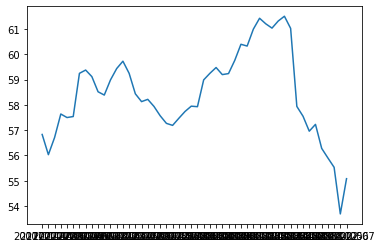

In [ ]:
plt.plot(df['date'].tail(50),df['open'].tail(50))

In [ ]:
series=df['close'].values.reshape(-1,1)
series.shape, df.shape

((1259, 1), (1259, 7))

In [ ]:
#normalize the data
scaler=StandardScaler()
scaler.fit(series[:len(series)//2])
series=scaler.transform(series)

In [ ]:
#build the dataset
T=20
D=1
X=[]
Y=[]

for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T,1)
Y=np.array(Y).reshape(-1,1)
N=len(X)
print("X.shape,", X.shape,'Y.shape', Y.shape)

X.shape, (1239, 20, 1) Y.shape (1239, 1)


In [ ]:
class RNN(nn.Module):
  def __init__(self,n_inputs,n_hidden,n_rnnlayers,n_outputs):
    super(RNN,self).__init__()
    self.D=n_inputs
    self.M=n_hidden
    self.K=n_outputs
    self.L=n_rnnlayers

    self.rnn=nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True
    )
    self.fc=nn.Linear(self.M,self.K)

  def forward(self,X):
    #initial hidden states
    h0=torch.zeros(self.L,X.size(0),self.M).to(device)
    c0=torch.zeros(self.L, X.size(0),self.M).to(device)

    #get RNN unit output

    out,_=self.rnn(X,(h0,c0))

    #we only want h(T) at the first time step
    out=self.fc(out[:,-1,:])
    return out

In [ ]:
model=RNN(1,5,1,1)

In [ ]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cpu


RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
#Loss and optimier
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
#Training
def full_gd(
    model,
    criterion,
    optimizer,
    X_train,
    y_train,
    X_test,
    y_test,
    epochs=200):
  
  #stuff to store
  train_losses=np.zeros(epochs)
  test_losses=np.zeros(epochs)

  for it in range(epochs):
    #first zero the param gradients
    optimizer.zero_grad()

    #forward pass
    outputs=model(X_train)
    loss=criterion(outputs,y_train)

    #backward and optimize
    loss.backward()
    optimizer.step()

    #save losses
    train_losses[it]=loss.item()

    #test loss
    test_outputs=model(X_test)
    test_loss=criterion(test_outputs,y_test)
    test_losses[it]=test_loss.item()

    if (it+1) % 5 == 0:
      print(f"Epoch {it+1}/{epochs}, Train loss:{loss.item():.4f},test loss:{test_loss.item():.4f}")

  return train_losses, test_losses

In [ ]:
#make inputs and targets
X_train=torch.from_numpy(X[:-N//2].astype(np.float32))
y_train=torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test=torch.from_numpy(X[N//2:].astype(np.float32))
y_test=torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
#move data to GPU
X_train, y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

In [ ]:
train_losses,test_losses= full_gd(
    model,
    criterion,
    optimizer,
    X_train,
    y_train,
    X_test,
    y_test)

Epoch 5/200, Train loss:0.4045,test loss:2.4062
Epoch 10/200, Train loss:0.1777,test loss:0.3321
Epoch 15/200, Train loss:0.0392,test loss:0.4869
Epoch 20/200, Train loss:0.0218,test loss:0.2800
Epoch 25/200, Train loss:0.0195,test loss:0.1120
Epoch 30/200, Train loss:0.0151,test loss:0.0899
Epoch 35/200, Train loss:0.0088,test loss:0.0515
Epoch 40/200, Train loss:0.0072,test loss:0.0488
Epoch 45/200, Train loss:0.0075,test loss:0.0384
Epoch 50/200, Train loss:0.0070,test loss:0.0355
Epoch 55/200, Train loss:0.0068,test loss:0.0388
Epoch 60/200, Train loss:0.0060,test loss:0.0350
Epoch 65/200, Train loss:0.0058,test loss:0.0416
Epoch 70/200, Train loss:0.0055,test loss:0.0362
Epoch 75/200, Train loss:0.0055,test loss:0.0388
Epoch 80/200, Train loss:0.0054,test loss:0.0385
Epoch 85/200, Train loss:0.0054,test loss:0.0376
Epoch 90/200, Train loss:0.0053,test loss:0.0373
Epoch 95/200, Train loss:0.0053,test loss:0.0371
Epoch 100/200, Train loss:0.0053,test loss:0.0359
Epoch 105/200, Train

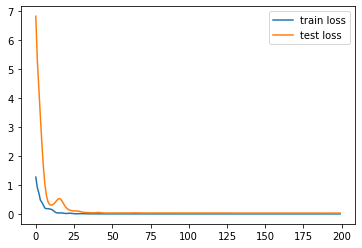

In [ ]:
#plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses,label='test loss')
plt.legend()
plt.show()

In [ ]:
#obtain one step forecast using true targets
validation_target=Y
validation_predictions=[]

#index of first validation input
i=0

X_on_device=torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
  input_=X_on_device[i].reshape(1,T,1)
  p=model(input_)[0,0].item() #1x1 array ->scalar
  i +=1

  #update the predictioons list
  validation_predictions.append(p)

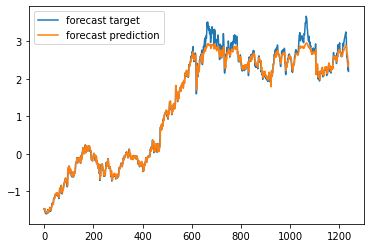

In [ ]:
plt.plot(validation_target,label='forecast target')
plt.plot(validation_predictions,label='forecast prediction')
plt.legend()

In [ ]:
#multi step-forecast
validation_target=Y[-N//2:]
validation_predictions=[]

In [ ]:
N/2 , N//2

(619.5, 619)

In [ ]:
last_x=X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_=last_x.reshape(1,T,1)
  p=model(input_)

  #[0,0] #1x1 array->scalar

  #update prediction list
  validation_predictions.append(p[0,0].item())

  #make new input
  last_x=torch.cat((last_x[1:],p[0]))

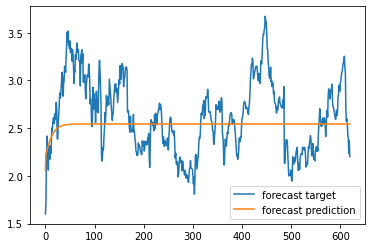

In [ ]:
plt.plot(validation_target,label='forecast target')
plt.plot(validation_predictions,label='forecast prediction')
plt.legend()

# PART 2 
## Stock Return Should be predicted R=Vf-Vi/Vi prices 

In [ ]:
# shift yesterday closing price alingned with todays closing price 
# then substract them in a one step to find R returns

In [ ]:
#calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) #move everything by 1

# so now it is like
# close /prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]

In [ ]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [ ]:
df.shape

(1259, 8)

In [ ]:
#the return is 
#(x[t]-x[t-1])/x[t-1]
df['Return']=(df['close']-df['PrevClose'])/df['PrevClose']

In [ ]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


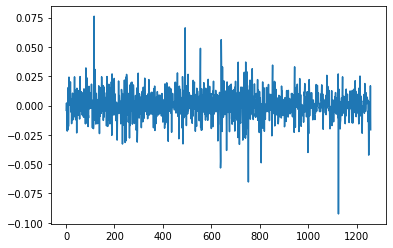

In [ ]:
plt.plot(df['Return'])

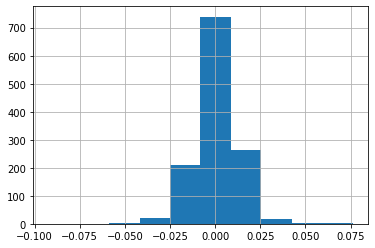

In [ ]:
df['Return'].hist()

In [ ]:
series=df['Return'].values[1:].reshape(-1,1)

#normalize the data
#Note: I didnt think about where the true boundary is,
# this is just approximation
scaler=StandardScaler()
scaler.fit(series[:len(series)//2])
series=scaler.transform(series).flatten()

In [ ]:
###build the dataset
#lets see if we can use T past values to predict the next value
T=20
D=1
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T,1)
Y=np.array(Y).reshape(-1,1)
N=len(X)

print("X.shape", X.shape,"Y.shape",Y.shape)

X.shape (1238, 20, 1) Y.shape (1238, 1)


In [ ]:
### try autoregressive RNN model
model=RNN(1,5,1,1)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
#Loss and optimizer
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [ ]:
#Make inputs and targets
X_train=torch.from_numpy(X[:-N//2].astype(np.float32))
y_train=torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test=torch.from_numpy(X[-N//2:].astype(np.float32))
y_test=torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
#move data to GPU
X_train, y_train=X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses= full_gd(
    model,
    criterion,
    optimizer,
    X_train,
    y_train,
    X_test,
    y_test
)

Epoch 5/200, Train loss:1.0735,test loss:1.0802
Epoch 10/200, Train loss:1.0589,test loss:1.0856
Epoch 15/200, Train loss:1.0584,test loss:1.0846
Epoch 20/200, Train loss:1.0540,test loss:1.0755
Epoch 25/200, Train loss:1.0525,test loss:1.0703
Epoch 30/200, Train loss:1.0525,test loss:1.0686
Epoch 35/200, Train loss:1.0519,test loss:1.0688
Epoch 40/200, Train loss:1.0509,test loss:1.0700
Epoch 45/200, Train loss:1.0501,test loss:1.0714
Epoch 50/200, Train loss:1.0492,test loss:1.0719
Epoch 55/200, Train loss:1.0482,test loss:1.0714
Epoch 60/200, Train loss:1.0472,test loss:1.0709
Epoch 65/200, Train loss:1.0461,test loss:1.0713
Epoch 70/200, Train loss:1.0448,test loss:1.0723
Epoch 75/200, Train loss:1.0433,test loss:1.0736
Epoch 80/200, Train loss:1.0417,test loss:1.0747
Epoch 85/200, Train loss:1.0399,test loss:1.0761
Epoch 90/200, Train loss:1.0382,test loss:1.0782
Epoch 95/200, Train loss:1.0367,test loss:1.0811
Epoch 100/200, Train loss:1.0352,test loss:1.0833
Epoch 105/200, Train

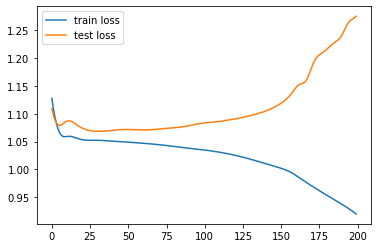

In [ ]:
#plot the train loss and test loss per interation
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='test loss')
plt.legend()
plt.show()

In [ ]:
# one-step forecast using true targets
validation_target=Y
validation_predictions=[]

#index of first validation input
i=0

X_on_device=torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(1,T,1)

  p=model(input_)[0,0].item() #1x1 array ->scalar
  i += 1
  #update the prediction list
  validation_predictions.append(p)

  

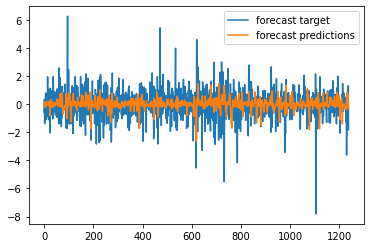

In [ ]:
plt.plot(validation_target,label='forecast target')
plt.plot(validation_predictions, label='forecast predictions')
plt.legend()

In [ ]:
#multi step forecast
validation_target=Y[-N//2:]
validation_predictions=[]

#last train input
last_x= X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_=last_x.reshape(1,T,1)
  p=model(input_)

  #[0,0] #1x1 array -> scalar

  #update the predictions list

  validation_predictions.append(p[0,0].item())

  last_x = torch.cat((last_x[1:],p[0]))

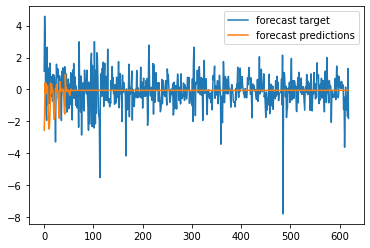

In [ ]:
plt.plot(validation_target,label='forecast target')
plt.plot(validation_predictions,label='forecast predictions')
plt.legend()

# Part 3 Binary Classification

In [ ]:
input_data=df[['open', "high", "low","close","volume"]].values
targets=df["Return"].values

In [ ]:
T=10 #number of steps to loos at to make
D=input_data.shape[1]
N=len(input_data)-T

In [ ]:
#normalize the input
Ntrain=len(input_data) *2//3
scaler=StandardScaler()
scaler.fit(input_data[:Ntrain+T-1])
input_data=scaler.transform(input_data)

In [ ]:
#setup X train and Y train
X_train=np.zeros((Ntrain,T,D))
Y_train=np.zeros((Ntrain,1))

for t in range(Ntrain):
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t]=(targets[t+T]>0)

In [ ]:
#setup Xtest and Ytest
X_test=np.zeros((N-Ntrain,T,D))
Y_test=np.zeros((N-Ntrain,1))

for u in range(N-Ntrain):
  #u counts from 0 to (N-Ntrain)
  # t counts from Ntrain to N
  t=u+Ntrain
  X_test[u,:,:]= input_data[t:t+T]
  Y_test[u]=(targets[t+T]>0)

In [ ]:
#make the RNN
model=RNN(5,50,2,1)
model.to(device)

RNN(
  (rnn): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
#loss and optimizer
criterion=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [ ]:
#make inputs and targets
X_train=torch.from_numpy(X_train.astype(np.float32))
y_train=torch.from_numpy(Y_train.astype(np.float32))
X_test=torch.from_numpy(X_test.astype(np.float32))
y_test=torch.from_numpy(Y_test.astype(np.float32))

In [ ]:
#move data to GPU
X_train, y_train= X_train.to(device) ,y_train.to(device)
X_test, y_test=X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses=full_gd(
    model,
    criterion,
    optimizer,
    X_train,
    y_train,
    X_test,
    y_test,
    epochs=300
)

Epoch 5/100, Train loss:0.6912,test loss:0.6924
Epoch 10/100, Train loss:0.6894,test loss:0.7442
Epoch 15/100, Train loss:0.6887,test loss:0.6895
Epoch 20/100, Train loss:0.6864,test loss:0.6993
Epoch 25/100, Train loss:0.6819,test loss:0.6908
Epoch 30/100, Train loss:0.6792,test loss:0.7012
Epoch 35/100, Train loss:0.6755,test loss:0.7003
Epoch 40/100, Train loss:0.6675,test loss:0.7026
Epoch 45/100, Train loss:0.6546,test loss:0.7133
Epoch 50/100, Train loss:0.6399,test loss:0.7275
Epoch 55/100, Train loss:0.6256,test loss:0.7418
Epoch 60/100, Train loss:0.6005,test loss:0.7617
Epoch 65/100, Train loss:0.5846,test loss:0.7724
Epoch 70/100, Train loss:0.5528,test loss:0.8031
Epoch 75/100, Train loss:0.5247,test loss:0.8466
Epoch 80/100, Train loss:0.4767,test loss:0.8662
Epoch 85/100, Train loss:0.4536,test loss:0.8875
Epoch 90/100, Train loss:0.4440,test loss:0.9526
Epoch 95/100, Train loss:0.3936,test loss:1.0485
Epoch 100/100, Train loss:0.3666,test loss:1.0987


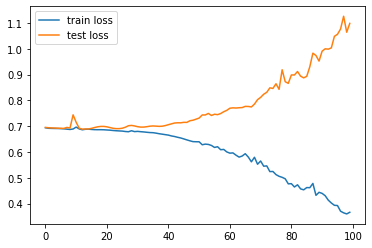

In [ ]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [ ]:
#get accuracy
with torch.no_grad():
  p_train=model(X_train)
  p_train=(p_train.cpu().numpy()>0)
  train_acc=np.mean(y_train.cpu().numpy()==p_train)

  p_test=model(X_test)
  p_test=(p_test.cpu().numpy()>0)
  test_acc=np.mean(y_test.cpu().numpy()==p_test)

print(f"train acc {train_acc:.4f}, test acc: {test_acc:.4f}")

train acc 0.8331, test acc: 0.4951
